In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as mcm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import LogNorm
from epiweeks import Week
from mpl_toolkits.axes_grid1 import make_axes_locatable
import baltic as bt
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd
from scipy.stats import gaussian_kde

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure X: Destination region of introductions into San Diego is dependent on lineage origin.
We plot the proportion of Markov jumps from Baja California that end up in each of San Diego's Health and Human Services region to determine how human mobility affects connectivity. We compare this against the proportion of jumps from all other locations as a null hypothesis.

Import the jumps from the discrete state analysis. This table is generated by running the `TreeMarkovJumpHistoryAnalyzer` on the posterior distribution of trees from the discrete-state reconstruction performed with BEAST.

In [3]:
jumps = pd.read_csv( "../data/2022-08-05_exponential_fixed_discrete_hhsa.Location.history.csv" )
jumps["date"] = jumps["time"].apply( dec_to_date )
jumps["date"] = jumps["date"].dt.normalize()
jumps.head()

,treeId,startLocation,endLocation,time,date
0,50000,Los Angeles,Rest of World,2022.399452,2022-05-26
1,50000,United States,Rest of World,2021.475083,2021-06-23
2,50000,Los Angeles,Rest of World,2022.021895,2022-01-08
3,50000,Los Angeles,Rest of World,2020.643817,2020-08-23
4,50000,Los Angeles,Rest of World,2021.654577,2021-08-27


Calculate the proportion of jumps from Baja California and all other locations into San Diego that end in each HHSA region.

In [4]:
# Baja California
jbc = jumps.loc[(jumps["startLocation"]=="Baja California")&(jumps["endLocation"].str.startswith( "San Diego"))]
plot_bc = jbc.pivot_table( index="treeId", columns="endLocation", values="time", aggfunc="count", fill_value=0 )
plot_bc = plot_bc.apply( lambda x: x/x.sum(), axis=1 )
plot_bc = plot_bc.agg( ["median", lambda x: x.quantile( 0.05 ), lambda x: x.quantile( 0.95)] ).T
plot_bc.columns = ["median", "quantile5", "quantil95"]

# All other locations
jrest = jumps.loc[(jumps["startLocation"]!="Baja California")&(jumps["endLocation"].str.startswith( "San Diego"))]
plot_rest = jrest.pivot_table( index="treeId", columns="endLocation", values="time", aggfunc="count", fill_value=0 )
plot_rest = plot_rest.apply( lambda x: x/x.sum(), axis=1 )
plot_rest = plot_rest.agg( ["median", lambda x: x.quantile( 0.05 ), lambda x: x.quantile( 0.95)] ).T
plot_rest.columns = ["median", "quantile5", "quantil95"]

# Combine the two locations while renaming the columns to reflect the source
plot_df = plot_rest.merge( plot_bc, left_index=True, right_index=True, suffixes=("_rest", "_bc") )
plot_df["diff"] = plot_df["median_bc"] - plot_df["median_rest"]
plot_df = plot_df.sort_values( "diff" ).reset_index()
plot_df

,endLocation,median_rest,quantile5_rest,quantil95_rest,median_bc,quantile5_bc,quantil95_bc,diff
0,San Diego-North Inland,0.063529,0.058559,0.067885,0.000000,0.000000,0.014925,-0.063529
1,San Diego-Other,0.418546,0.396752,0.439506,0.363636,0.284091,0.465116,-0.054910
2,San Diego-North Central,0.152913,0.139759,0.167033,0.111111,0.000000,0.168421,-0.041802
3,San Diego-North Coastal,0.040964,0.037209,0.044118,0.000000,0.000000,0.000000,-0.040964
4,San Diego-South,0.129676,0.117788,0.142518,0.141026,0.084337,0.197368,0.011350
5,San Diego-East,0.115942,0.104167,0.129771,0.174757,0.109756,0.237288,0.058815
6,San Diego-Central,0.078049,0.065693,0.089862,0.206522,0.151786,0.272727,0.128473


Calculate the probability that proportionally more jumps from Baja California land in each region than from all other locations.

In [6]:
jumps_collapse = jumps.copy()
jumps_sd = jumps_collapse.loc[jumps_collapse["endLocation"].str.startswith( "San Diego")]
jumps_sd.loc[jumps_sd["startLocation"]!="Baja California","startLocation"] = "Rest"
jumps_sd = jumps_sd.pivot_table( index="treeId", columns=["startLocation","endLocation"], values="time", aggfunc="count", fill_value=0 )
prob = jumps_sd["Baja California"].apply( lambda x: x/x.sum(), axis=1 ) - jumps_sd["Rest"].apply( lambda x: x/x.sum(), axis=1 )
prob = prob.agg( ["median", lambda x: x.quantile( 0.05 ), lambda x: x.quantile( 0.95), lambda x: sum( x > 0 ) / len( x )] ).T
prob.columns = ["median", "quantile5", "quantil95", "prob"]
prob = prob.reindex( index=plot_df["endLocation"] ).reset_index()
prob

,endLocation,median,quantile5,quantil95,prob
0,San Diego-North Inland,-0.063415,-0.067885,-0.044055,0.004734
1,San Diego-Other,-0.056256,-0.150305,0.065576,0.204103
2,San Diego-North Central,-0.041971,-0.164706,0.024660,0.147817
3,San Diego-North Coastal,-0.040964,-0.044118,-0.036446,0.011047
4,San Diego-South,0.011592,-0.056208,0.077758,0.614413
5,San Diego-East,0.059113,-0.018573,0.129945,0.909521
6,San Diego-Central,0.130068,0.064662,0.203456,0.998948


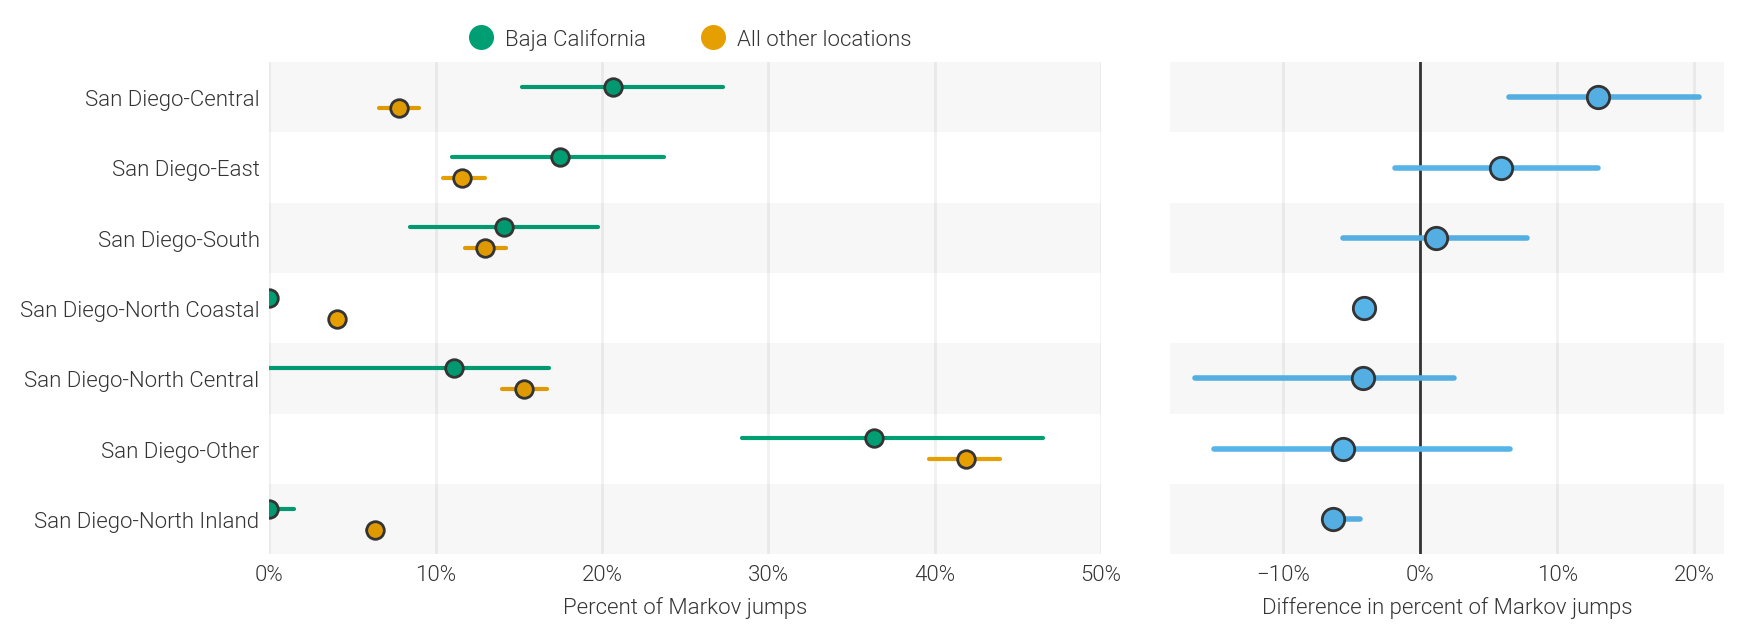

In [10]:
def plot_proportions( ax, df ):
    ax.scatter( df["median_rest"], df.index-0.15, s=40, color="#E69F00", zorder=5, edgecolor=COLOR, linewidths=1 )
    ax.scatter( df["median_bc"], df.index+0.15, s=40, color="#009E73", zorder=5, edgecolor=COLOR, linewidths=1 )
    ln = ax.hlines( df.index-0.15, xmin=df["quantile5_rest"], xmax=df["quantil95_rest"], color="#E69F00", zorder=4 )
    ln.set_capstyle( "round" )
    ln = ax.hlines( df.index+0.15, xmin=df["quantile5_bc"], xmax=df["quantil95_bc"], color="#009E73", zorder=4 )
    ln.set_capstyle( "round" )

    ax.set_yticks( df.index )
    ax.set_yticklabels( df["endLocation"] )
    basic_formatting( ax, spines=[], which="x", xlabel="Percent of Markov jumps", xlims=(0, 0.5), ylims=(-0.5, 6.5), ysize=8, xsize=8 )

    ax.xaxis.set_major_formatter( PercentFormatter( 1, decimals=0 ) )
    ax.tick_params( axis="x", which="both", rotation=0, pad=0 )

    for i in range( 0, len( df.index ), 2):
        ax.axhspan( i-0.5,i+0.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0, zorder=5 )

    legend = [Line2D([0], [0], linestyle='none', marker='o', color="#009E73", label="Baja California", markersize=8 ),
              Line2D([0], [0], linestyle='none', marker='o', color="#E69F00", label="All other locations", markersize=8 )]
    ax.legend( loc="upper center", handletextpad=0.1, handles=legend, frameon=False, fontsize=8, ncol=2,
              bbox_to_anchor=(0,0,1.00,1.11) )

def plot_difference( ax, df ):
    ax.scatter( df["median"],prob.index, s=65, color="#56B4E9", zorder=5, edgecolor=COLOR, linewidths=1 )
    ln = ax.hlines( df.index, xmin=df["quantile5"], xmax=df["quantil95"], color="#56B4E9", linewidth=2, zorder=4 )
    ln.set_capstyle( "round" )

    ax.axvline( 0, color=COLOR, linewidth=1, zorder=2 )

    ax.set_yticks( df.index )
    ax.set_yticklabels( df["endLocation"] )
    basic_formatting( ax, spines=[], which="x", xlabel="Difference in percent of Markov jumps", ylims=(-0.5, 6.5), ysize=8, xsize=8 )

    ax.xaxis.set_major_formatter( PercentFormatter( 1, decimals=0 ) )
    ax.tick_params( axis="x", which="both", rotation=0, pad=0 )

    for i in range( 0, len( df.index ), 2):
        ax.axhspan( i-0.5,i+0.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0, zorder=5 )

fig, axis = plt.subplots( dpi=200, figsize=(9,3.5), ncols=2, sharey=True, gridspec_kw={"width_ratios" :(0.6, 0.4)} )
plot_proportions( axis[0], plot_df )
plot_difference( axis[1], prob )
axis[1].label_outer()
plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_cross-border-introductions-destination.pdf" )
plt.show()